In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
train = pd.read_csv('train.csv')

# Drop high-cardinality and unneeded columns
train = train.drop(columns=['id', 'Episode_Title'])

# Drop missing values for simplicity
train = train.dropna()

# Set categorical features
categorical_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
for col in categorical_cols:
    train[col] = train[col].astype('category')

# Log-transform the target
train['Listening_Log'] = np.log1p(train['Listening_Time_minutes'])

# Define X and transformed y
X = train.drop(columns=['Listening_Time_minutes', 'Listening_Log'])
y_log = train['Listening_Log']


In [3]:
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


### Training lightgbm on Log-Target

In [6]:
lgb_model_log = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

lgb_model_log.fit(
    X_train,
    y_train_log,
    categorical_feature=categorical_cols
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 431238, number of used features: 9
[LightGBM] [Info] Start training from score 3.591692


LGBMRegressor(learning_rate=0.05, n_estimators=500, n_jobs=-1, random_state=42)

### Predict and inverse transform

In [9]:
# Predict (log space)
y_pred_log = lgb_model_log.predict(X_val)

# Invert transformation
y_pred = np.expm1(y_pred_log)         # Model predictions
y_val_true = np.expm1(y_val_log)      # True targets


### Evaluate on Original Scale

In [12]:
rmse = mean_squared_error(y_val_true, y_pred, squared=False)
mae = mean_absolute_error(y_val_true, y_pred)
r2 = r2_score(y_val_true, y_pred)

print(f"LightGBM (Log Target) RMSE: {rmse:.2f}")
print(f"LightGBM (Log Target) MAE: {mae:.2f}")
print(f"LightGBM (Log Target) R²: {r2:.4f}")


LightGBM (Log Target) RMSE: 10.53
LightGBM (Log Target) MAE: 8.11
LightGBM (Log Target) R²: 0.8498


C:\Users\james\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Residual Check

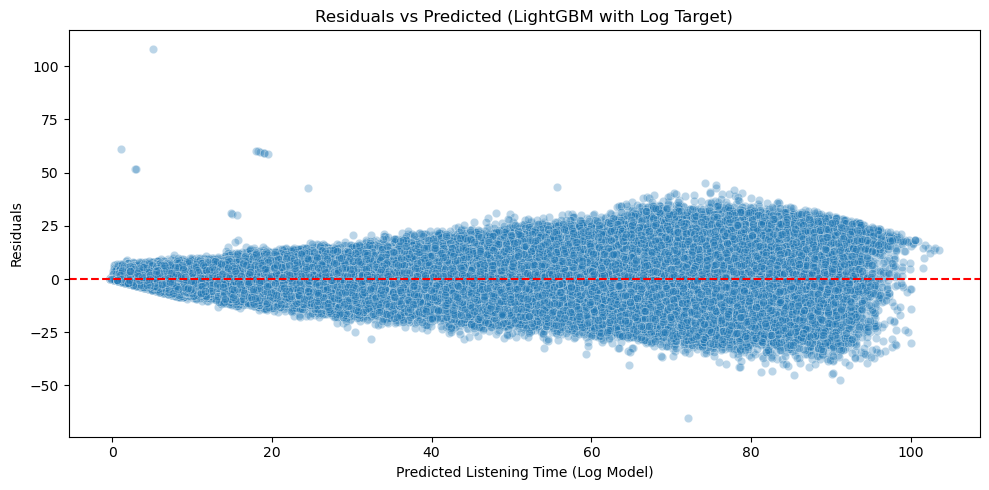

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals on original scale
residuals_log = y_val_true - y_pred

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals_log, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Listening Time (Log Model)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (LightGBM with Log Target)')
plt.tight_layout()
plt.show()


##  LightGBM with Log-Transformed Target

To address potential heteroskedasticity and outlier influence in the `Listening_Time_minutes` target variable, we trained a LightGBM model using a **log-transformed target**. This is a common technique when the target is skewed or residuals increase with the target value.

###  Workflow Summary

1. Categorical variables were handled natively using LightGBM's `categorical_feature` support.
2. The target variable `Listening_Time_minutes` was transformed using `np.log1p()`, and predictions were later back-transformed with `np.expm1()` for evaluation.
3. The model was trained and evaluated using a standard 80/20 train-validation split.

---

###  Performance Metrics (Validation Set)

| Metric   | Value  |
|----------|--------|
| RMSE     | 10.53 minutes |
| MAE      | 8.11 minutes |
| R²       | 0.8498       |

Performance was **comparable** to the non-transformed LightGBM model. The log transformation did not improve predictive accuracy, but it also did not hurt it. It remains a valid preprocessing option to test, particularly in the presence of outliers.

---

###  Residual Analysis

- Residuals remained centered around zero and generally well-behaved.
- A **funnel-shaped pattern** was still observed, indicating the model has more uncertainty when predicting longer listening times.
- No major structural patterns or curvature was present — suggesting LightGBM captured the main relationships.

---

###  Key Takeaways

- Log-transforming the target **did not significantly improve** model performance in this case.
- The same residual patterns observed earlier remain, suggesting that further improvements will likely come from **better feature engineering**, not just transformation.
- Native categorical support continued to perform well and gave more meaningful feature importances.

---

###  Next Step: Feature Engineering

We will now focus on engineering new interaction, density, and aggregated features to provide additional predictive signal and help the model better handle edge cases — particularly for longer listening times.
